# Along-isobath averaging

This recipe shows how to perform an along-isobath averaging for scalar quantities (and vector quantities that are not rotated to along- and across-contour) in ACCESS-OM2-01.

Such along-isobath averaging is relevant for Antarctic shelf analyses, where a zonal average over a section of cross-shelf regions is needed.


### Some caveats: 

1) If there are deep valleys or troughs around the coastline, those will be averaged with deeper isobaths further offshore. Similarly, if there are seamounts off-shore, these will be averaged with shallower regions on the continental slope. Careful adjustment of the mask is necessary to ensure your results are interpretable. 

2) The bottom depths in ht and hu reflect the adaptive vertical grid in ACCESS, but the variables have NaNs at some of these depths. So, we end up with uneven binning if we bin along isobaths which do not exist in the variable field. As a simple fix, we mask our region of interest by `ht` and `hu`, but we bin by the bottom depth derived from the 3D variables (e.g., temperature) -- these are the `hu_coarse` and `ht_coarse` variables. This workaround can be further inspected in the future. 

#### Resources

This recipe was generated on a Large ARE instance, and may not work on smaller sizes.
___

This notebook was run with `PYTHONWARNINGS="ignore"` set in the environment variables. We do not recommend doing so as it may hide useful information. However, for the purposes of this recipe, it was necessary to hide these warnings. If you run this recipe without `PYTHONWARNINGS="ignore"` set, you may see a number of additional warnings. 

Load the necessary modules.

In [1]:
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xhistogram.xarray import histogram
from dask.distributed import Client

import warnings, os
# Set warnings to only show once - we are going to get a lot of repetitive warnings later on
warnings.filterwarnings(action='once',category=RuntimeWarning)
warnings.filterwarnings(action='once',category=FutureWarning)
os.environ["PYTHONWARNINGS"] = "once" # This gets subprocesses - like dask workers - to follow this too


In [2]:
client = Client(threads_per_worker = 1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36729 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36729/status,
Dashboard: /proxy/36729/status,Workers: 48
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39791,Workers: 0
Dashboard: /proxy/36729/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43723,Total threads: 1
Dashboard: /proxy/34009/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:36841,


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [3]:
catalog = intake.cat.access_nri
experiment = '01deg_jra55v13_ryf9091' # the RYF90-91 experiment

esm_ds = catalog[experiment]
esm_ds

,unique
filename,3469
path,11947
file_id,22
frequency,5
start_date,3361
end_date,3360
variable,205
variable_long_name,197
variable_standard_name,36
variable_cell_methods,3


Note that the bathymetry provided by `ht` and `hu` is not discretised into the same bins as `st_ocean(_edges)`. The histogram function in this code thus yields uneven bins if we bin `ht` by `st_ocean_edges` bins. As a result, we use `ht` and `hu` for our masking, but we obtain bottom bathymetry from the variable itself, which _is_ discretised into `st_ocean bins`. 

### 1. Define your region of interest. 
Bathymetry variables, `ht` and `hu`, are used for masking unwanted deep regions on the continental shelf and shallow regions offshore.

In [4]:
# Search for bathymetry - on u and t grid. 
esm_ds.search(variable=['hu','ht'])

,unique
filename,1
path,1116
file_id,1
frequency,1
start_date,1116
end_date,1116
variable,20
variable_long_name,20
variable_standard_name,2
variable_cell_methods,2


They're both in a single dataset, so we can load them together using `.to_dask()`. We use `xarray_open_kwargs = {'chunks' : "auto"}` to let dask determine the chunks. We also set `"decode_timedelta" : False` to disable a bunch of useless warnings related to a library change.


In [5]:
bathy = esm_ds.search(variable=['hu','ht']).to_dask(
    xarray_open_kwargs={
        "chunks" : "auto",
    }
)

hu = bathy['hu']
ht = bathy['ht']
hu

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/argopy/__init__.py:32: DeprecationWarning: The 'argopy.utilities' has moved to 'argopy.utils'. After 0.1.15, importing 'utilities' will raise an error. Please update your script.
  from . import utilities  # noqa: E402  # being deprecated until 0.1.15, then remove
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/argopy/__init__.py:32: DeprecationWarning: The 'argopy.utilities' has moved to 'argopy.utils'. After 0.1.15, importing 'utilities' will raise an error. Please update your script.
  from . i

<xarray.DataArray 'hu' (yu_ocean: 2700, xu_ocean: 3600)> Size: 39MB
dask.array<open_dataset-hu, shape=(2700, 3600), dtype=float32, chunksize=(2700, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 22kB -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
    geolon_c  (yu_ocean, xu_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_c  (yu_ocean, xu_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Attributes:
    long_name:     ocean depth on u-cells
    units:         m
    valid_range:   [-1.e+09  1.e+09]
    cell_methods:  time: point

As a simple example, we mask out everything but the Ross Sea shallower than 2000 meters.
Alternatively, users can define any polygon as their mask.

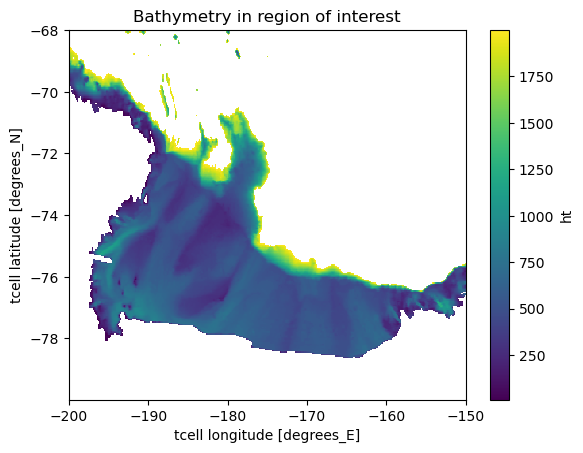

In [6]:
# Define the region of interest
lon_slice = slice(-200, -150)
lat_slice = slice(-80, -68)
mask_depth = 2000

# select correct extent of ht, hu for use later:
ht = ht.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice)
hu = hu.sel(xu_ocean=lon_slice).sel(yu_ocean=lat_slice)

# create masks:
mask_t = ht.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice) < mask_depth
mask_u = hu.sel(xu_ocean=lon_slice).sel(yu_ocean=lat_slice) < mask_depth
mask_t = mask_t.where(mask_t != 0)
mask_u = mask_u.where(mask_u != 0)

# mask bathymetry:
hu_masked = hu * mask_u
ht_masked = ht * mask_t

# Plot the bathymetry in the mask region:
ht_masked.plot()
plt.title('Bathymetry in region of interest')
plt.show()

### 2. Import variables for averaging, set up thickness and area for weighting, and isobath bins.

In [7]:
# Import properties to average along isobaths.

# Define the start and end times #
start_time, end_time = '2170-01-01', '2179-12-16'
# For searching with the intake catalog, we can use wildcard searches: so start_date = '217[0,9].*' means any date starting with 2170,2171..2179
# See https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html#data-discovery for more info

# Define the variables we want to load
variables =['salt','temp','pot_rho_0','u','v']

esm_ds.search(variable=variables,frequency='1mon', start_date='217[0,9].*')

,unique
filename,1
path,8
file_id,1
frequency,1
start_date,8
end_date,8
variable,46
variable_long_name,42
variable_standard_name,11
variable_cell_methods,2


All our variables are in the one dataset - so we can load them all at once - this is more efficient than doing things separately

In [8]:
# Load the dataset
var_dataset = esm_ds.search(
    variable=variables,frequency='1mon', start_date='217[0,9].*'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
# Select out slice
var_dataset = var_dataset.sel(time=slice(start_time, end_time)).sel(yt_ocean=lat_slice)

# Separate our variables into data arrays
temp = var_dataset['temp']
salt = var_dataset['salt']
density = var_dataset['pot_rho_0']
u = var_dataset['u']
v = var_dataset['v']


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


Compute volume and area for weighted averaging using `xhistogram` package.

Note that the thickness here is **not** time-varying. Use `dzt` for time-varying thickness if necessary.

In [9]:
esm_ds.search(variable='st_ocean',frequency='1mon').unique().file_id

['ocean.1mon.grid_xt_ocean:3600.grid_xu_ocean:3600.grid_yt_ocean:2700.grid_yu_ocean:2700.neutral:80.neutralrho_edges:81.nv:2.potrho:80.potrho_edges:81.st_edges_ocean:76.st_ocean:75.sw_edges_ocean:76.sw_ocean:75.xt_ocean:3600.xu_ocean:3600.yt_ocean:2700.yu_ocean:2700',
 'ocean.1mon.nv:2.st_edges_ocean:76.st_ocean:75.xt_ocean:3600.yt_ocean:2700']

In [10]:
%%time
grid_vars = ['xt_ocean','yt_ocean','st_edges_ocean','st_ocean']
coord_ds = esm_ds.search(
    variable=grid_vars, 
    file_id='ocean.1mon.grid_xt_ocean:3600.grid_xu_ocean:3600.grid_yt_ocean:2700.grid_yu_ocean:2700.neutral:80.neutralrho_edges:81.nv:2.potrho:80.potrho_edges:81.st_edges_ocean:76.st_ocean:75.sw_edges_ocean:76.sw_ocean:75.xt_ocean:3600.xu_ocean:3600.yt_ocean:2700.yu_ocean:2700',
    frequency='1mon'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
xt_ocean = coord_ds['xt_ocean'].sel(xt_ocean=lon_slice)
yt_ocean = coord_ds['yt_ocean'].sel(yt_ocean=lat_slice)
st_ocean = coord_ds['st_ocean']

st_edges_ocean = coord_ds['st_edges_ocean']
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean': yt_ocean, 'xt_ocean': xt_ocean}, axis=[1, 2])

# adjust for partial bottom cells:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# area_t is in a different dataset - so we need to load it separately.
area_t = esm_ds.search(variable='area_t').to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
        "decode_timedelta" : False,
    }
)['area_t']
area_t = area_t.sel(yt_ocean=lat_slice)

volume = area_t * thickness

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:306: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid

CPU times: user 11.3 s, sys: 1.66 s, total: 12.9 s
Wall time: 11.5 s


In [11]:
%%time
# As above, for the u-grid #
grid_vars = ['xu_ocean','yu_ocean','st_edges_ocean','st_ocean']
coord_ds = esm_ds.search(
    variable=grid_vars,
    file_id='ocean.1mon.grid_xt_ocean:3600.grid_xu_ocean:3600.grid_yt_ocean:2700.grid_yu_ocean:2700.neutral:80.neutralrho_edges:81.nv:2.potrho:80.potrho_edges:81.st_edges_ocean:76.st_ocean:75.sw_edges_ocean:76.sw_ocean:75.xt_ocean:3600.xu_ocean:3600.yt_ocean:2700.yu_ocean:2700',
    frequency='1mon'
).to_dask(
    xarray_open_kwargs={
        'chunks' : "auto",
    }
)
xu_ocean = coord_ds['xu_ocean'].sel(xu_ocean=lon_slice)
yu_ocean = coord_ds['yu_ocean'].sel(yu_ocean=lat_slice)
st_ocean = coord_ds['st_ocean']

st_edges_ocean = coord_ds['st_edges_ocean']
st_edges_array = st_edges_ocean.expand_dims({'yu_ocean': yu_ocean, 'xu_ocean': xu_ocean}, axis=[1, 2])

# adjust for partial bottom cells:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu, other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# area_u is in a different dataset - so we need to load it separately.
area_u = esm_ds.search(variable='area_u').to_dask(xarray_open_kwargs={'chunks' : "auto"})['area_u']
area_u = area_u.sel(yu_ocean=lat_slice)

volume_u = area_u * thickness


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/source.py:306: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid

CPU times: user 10.9 s, sys: 1.24 s, total: 12.1 s
Wall time: 10.3 s


In [12]:
### MASK YOUR REGION OF INTEREST ###

volume_masked = volume * mask_t
volume_u_masked = volume_u * mask_u
area_t_masked = area_t * mask_t
area_u_masked = area_u * mask_u
temp_masked = temp * mask_t
salt_masked = salt * mask_t
density_masked = density * mask_t
u_masked = u * mask_u

As mentioned above, we don't use `ht` and `hu` for the histogram binning below, as our variable depth bins are `st_edges_ocean`, while `ht` and `hu` have much finer resolution, leading to uneven bins.

Below, we isolate the bottom `st_ocean` from the `temp` dataarray (as `ht_coarse`) and from `u` (as `hu_coarse`) that isn't NaN. This is the variable over which we perform the binning. Note that we assume that NaN grid cells are NaN at all times (i.e., `ht_coarse` and `hu_coarse` don't change over time).


In [13]:
%%time

###### T-GRID ######

# Create an empty DataArray with the same shape as 'temp_avg'
temp_avg = temp_masked.mean('time')
full_st_ocean_t = xr.full_like(temp_avg, np.nan)

# Assign the 1D st_ocean coordinate to the new DataArray, broadcasting along the other dimensions
full_st_ocean_t.data = np.broadcast_to(temp_avg.st_ocean.values[:, np.newaxis, np.newaxis], temp_avg.shape)
full_st_ocean_t_masked = full_st_ocean_t*temp_avg / temp_avg # Here, we mask by temp_avg to ensure the Nans are preserved 

# Now 'full_st_ocean_t_masked' is a 3D DataArray with 'st_ocean' values broadcasted along yt_ocean and xt_ocean
# and masked by temp_avg

# Find the bottom depth for each (yt_ocean, xt_ocean) coordinate
ht_coarse = full_st_ocean_t_masked.max(dim='st_ocean').rename('ht_coarse')

###### U-GRID ######

# Create an empty DataArray with the same shape as 'u_avg'
u_avg = u_masked.mean('time')
full_st_ocean_u = xr.full_like(u_avg, np.nan)

# Assign the 1D st_ocean coordinate to the new DataArray, broadcasting along the other dimensions
full_st_ocean_u.data = np.broadcast_to(u_avg.st_ocean.values[:, np.newaxis, np.newaxis], u_avg.shape)
full_st_ocean_u_masked = full_st_ocean_u * u_avg / u_avg # Here, we mask by u_avg to ensure the Nans are preserved

# Now 'full_st_ocean_u_masked' is a 3D DataArray with 'st_ocean' values broadcasted along yu_ocean and xu_ocean
# and masked by u_avg

# Find the bottom depth for each (yu_ocean, xu_ocean) coordinate
hu_coarse = full_st_ocean_u_masked.max(dim='st_ocean').rename('hu_coarse')

CPU times: user 106 ms, sys: 72.2 ms, total: 179 ms
Wall time: 131 ms


### 3. Bin variables into isobath depth!

Here, we bin the variables of interest by isobath using the `xhistogram` package.

First, we define the edges of the isobath bins. It does make sense for these to be the same as `st_edges_ocean` because that is the vertical resolution of the ACCESS-OM2-01 model.

In [14]:

bins_isobath = st_edges_ocean.where(st_edges_ocean<=mask_depth).dropna(dim='st_edges_ocean').values

# Next, we sum the volume-weighted variable of interest along that isobath using xhistogram
V_sum = histogram(ht_coarse, bins = bins_isobath,
                  dim = ['yt_ocean', 'xt_ocean'],
                  weights = volume_masked)
Vu_sum = histogram(hu_coarse, bins = bins_isobath,
                   dim = ['yu_ocean', 'xu_ocean'],
                   weights = volume_u_masked)

A_sum = histogram(ht_coarse, bins = bins_isobath,
                  dim = ['yt_ocean', 'xt_ocean'],
                  weights = area_t_masked)
Au_sum = histogram(hu_coarse, bins = bins_isobath,
                   dim = ['yu_ocean', 'xu_ocean'],
                   weights = area_u_masked)

TV_sum = histogram(ht_coarse, bins = bins_isobath,
                   dim = ['yt_ocean', 'xt_ocean'],
                   weights = volume_masked * temp_masked)
SV_sum = histogram(ht_coarse, bins = bins_isobath,
                   dim = ['yt_ocean', 'xt_ocean'],
                   weights = volume_masked * salt_masked)
rhoV_sum = histogram(ht_coarse, bins = bins_isobath,
                     dim = ['yt_ocean', 'xt_ocean'],
                     weights = volume_masked * density_masked)
uV_sum = histogram(hu_coarse, bins = bins_isobath,
                   dim = ['yu_ocean', 'xu_ocean'],
                   weights = volume_u_masked * u_masked)

# Finally, we divide the summed, volume-weighted variable of interest by volume, to get a mean along an isobath

T_mean = TV_sum / V_sum
S_mean = SV_sum / V_sum
rho_mean = rhoV_sum / V_sum
u_mean = uV_sum / Vu_sum

The binning above creates an averaged field as a function of isobath.

Let's plot this to see what it looks like!

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 163.75 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide


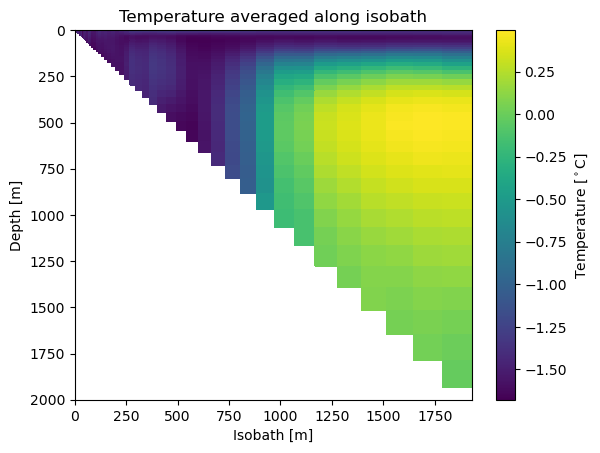

In [15]:
plt.pcolor(T_mean.ht_coarse_bin, st_ocean, T_mean.mean('time') - 273.15)
plt.gca().invert_yaxis()
plt.ylim(2000,0)
plt.xlabel('Isobath [m]')
plt.ylabel('Depth [m]')
plt.colorbar(label = 'Temperature [$^\circ$C]')
plt.title('Temperature averaged along isobath');

## Each variable is averaged along isobaths, so the bathymetry looks diagonal in the plot #

We can rescale the isobath (x-axis) to be scaled by the cumulative surface area covered by each isobath, from shallowest to deepest. This produces a "normalised area" or pseduo-latitude $x$-axis.

In [16]:
normalised_area_cumsum = (A_sum.cumsum('ht_coarse_bin') / np.nansum(A_sum)).values
normalised_area_cumsum_u = (Au_sum.cumsum('hu_coarse_bin') / np.nansum(Au_sum)).values

lat_max, lat_min = abs(mask_t.yt_ocean.max().values), abs(mask_t.yt_ocean.min().values)

## Here, we plot the averaged quantities as a function of normalised area (between 0 and 1)
## and pseudo-latitude
def normalised_to_pseudo_lat(normalised_area):
    return -1 * (lat_min - (lat_min - lat_max) * normalised_area)

def pseudo_lat_to_normalised(pseudo_lat):
    return (lat_min + pseudo_lat) / (lat_min - lat_max)

pseudo_lat = normalised_to_pseudo_lat(normalised_area_cumsum)
pseudo_lat_u = normalised_to_pseudo_lat(normalised_area_cumsum_u)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 81.39 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 81.39 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/distributed/cli

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_c

CPU times: user 38.5 s, sys: 8.9 s, total: 47.4 s
Wall time: 57.8 s


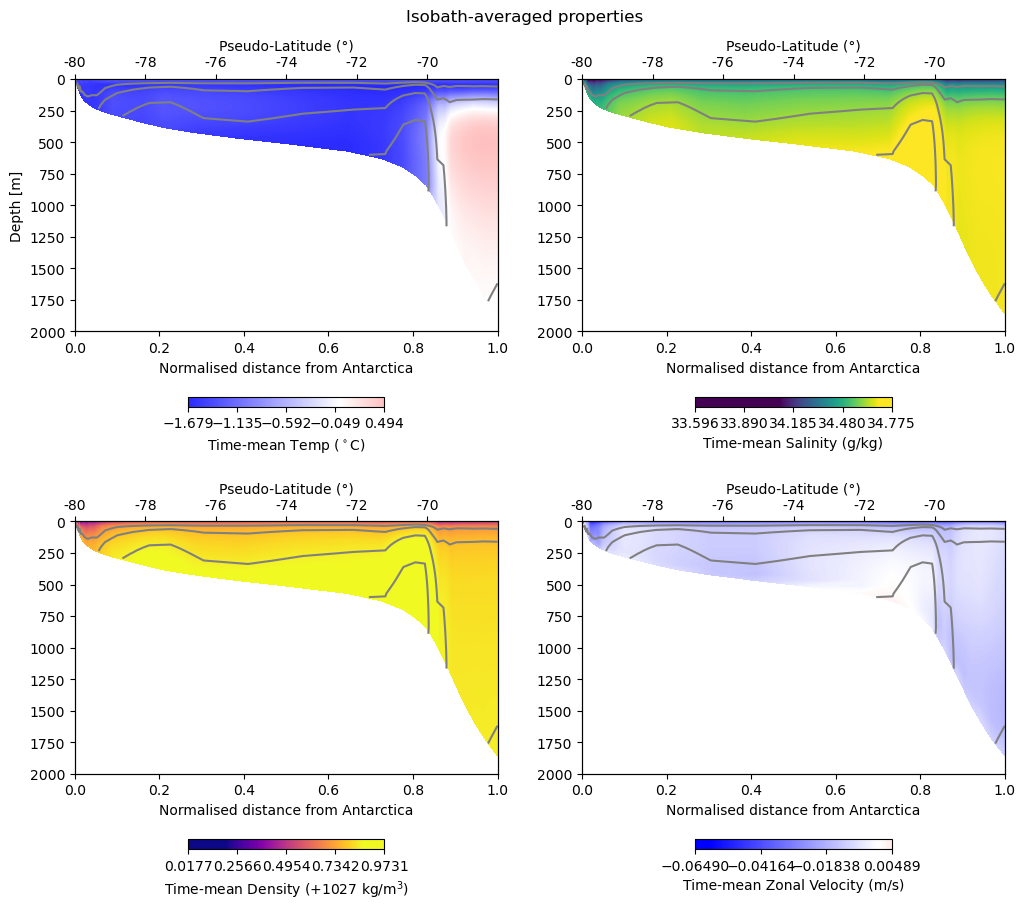

In [17]:
%%time
## Finally, plot the isobath-averaged properties. This should take about 3 minutes on a Large ARE Instance


fig, axs = plt.subplots(2, 2, figsize=(12, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.35, wspace=0.2)
axs = axs.ravel()

fontsize = 13

im1 = axs[0].contourf(normalised_area_cumsum, st_ocean, T_mean.mean('time') - 273.15, levels=500,
                      vmin=-2, vmax=2, cmap=plt.cm.bwr)
im2 = axs[1].contourf(normalised_area_cumsum, st_ocean, S_mean.mean('time'), levels=500, vmin=34.1,
                      vmax = 34.7, cmap=plt.cm.viridis)
im3 = axs[2].contourf(normalised_area_cumsum, st_ocean, rho_mean.mean('time') - 1027, levels=500,
                      vmin=0.2, vmax=0.87, cmap=plt.cm.plasma)
im4 = axs[3].contourf(normalised_area_cumsum_u, st_ocean, u_mean.mean('time'), levels=500,
                      vmin=-0.06, vmax=0.06, cmap=plt.cm.bwr)

density_contours = np.linspace(1027.7, 1028, 5)

for i, ax in enumerate(axs):
    cont = ax.contour(normalised_area_cumsum_u, st_ocean, rho_mean.mean('time'), density_contours,
                      colors='gray', zorder=2, fontsize=fontsize)
    ax.invert_yaxis()
    ax.set_xlabel('Normalised distance from Antarctica')
    ax.set_ylim(mask_depth, 0)

    # Secondary x-axis: pseudo_lat
    twin_ax = ax.twiny()
    twin_ax.set_xlim(ax.get_xlim())  # Align the limits to match the shared x-axis
    twin_ax.set_xticks(pseudo_lat_to_normalised(np.arange(-80, -68, 2)))  # Match tick positions
    twin_ax.set_xticklabels(np.arange(-80, -68, 2))  # Replace tick labels with pseudo_lat values
    twin_ax.set_xlabel('Pseudo-Latitude (°)')

axs[0].set_ylabel('Depth [m]')

cb1 = plt.colorbar(im1, ax=axs[0], fraction=0.03, pad=0.2, orientation='horizontal')
cb2 = plt.colorbar(im2, ax=axs[1], fraction=0.03, pad=0.2, orientation='horizontal')
cb3 = plt.colorbar(im3, ax=axs[2], fraction=0.03, pad=0.2, orientation='horizontal')
cb4 = plt.colorbar(im4, ax=axs[3], fraction=0.03, pad=0.2, orientation='horizontal')

cb1.set_label('Time-mean Temp ($^\circ$C)')
cb2.set_label('Time-mean Salinity (g/kg)')
cb3.set_label('Time-mean Density (+1027 kg/m$^3$)')
cb4.set_label('Time-mean Zonal Velocity (m/s)')

cb1.set_ticks(np.linspace(np.min(T_mean.mean('time') - 273.15), np.max(T_mean.mean('time') - 273.15), 5))
cb2.set_ticks(np.linspace(np.min(S_mean.mean('time')), np.max(S_mean.mean('time')), 5))
cb3.set_ticks(np.linspace(np.min(rho_mean.mean('time') - 1027), np.max(rho_mean.mean('time') - 1027), 5))
cb4.set_ticks(np.linspace(np.min(u_mean.mean('time')), np.max(u_mean.mean('time')), 4))

plt.suptitle('Isobath-averaged properties', y=0.95);
